In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import unicodedata
import nltk

import prepare
import acquire

from env import username, password, host

### Spam Data

- Load the spam data set.
- Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
- Is there any overlap in the bigrams for the spam data and the ham data?
- Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [4]:
def get_db_url(database, host=host, user=username, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
#Prepare the data
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [7]:
#Create three dataframes for ham, spam, and all words



#First create series for each category
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

#Second create frequency counts for words
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()


#Third, create a concatenated dataframe
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [8]:
#Create the bigrams for the spam data
spam_bigrams = (pd.Series(nltk.ngrams(ham_words, 2)).value_counts())

spam_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

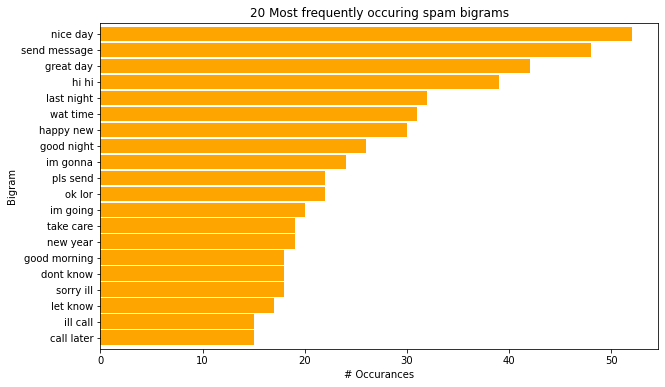

In [12]:
#Visualize the bigrams with barplot
top_20_spam_bigrams = spam_bigrams.sort_values(ascending=False).head(20)

top_20_spam_bigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10,6))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


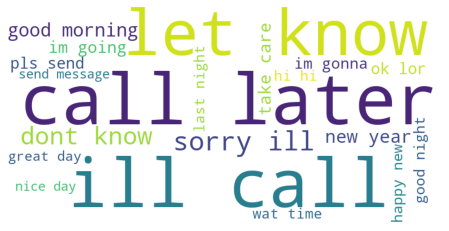

In [13]:
#Visualize with wordcloud
data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

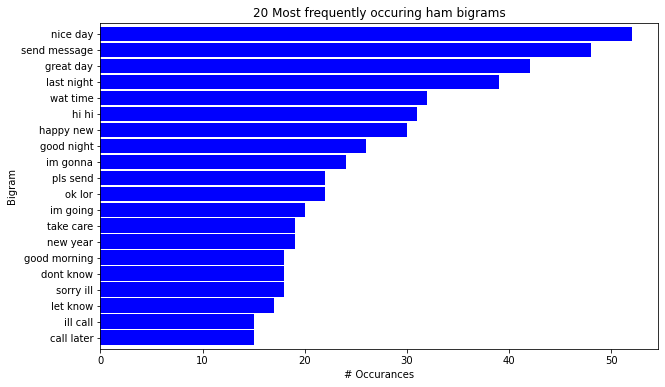

In [14]:
#Create a series with the ham bigrams
ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2)).value_counts().head(20))

#Just the top 20
top_20_ham_bigrams = ham_bigrams.sort_values(ascending=False).head(20)

#Create the plot
top_20_ham_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10,6))

#Set the labels
plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

#Clean up formatting for labels
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

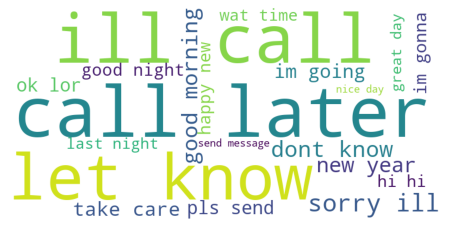

In [15]:
#Create the wordcloud for ham bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


In [16]:
#Create the trigrams for ham and spam
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3)).value_counts().head(20))
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3)).value_counts().head(20))


In [18]:
top_20_ham_trigrams

(ill, call, later)             42
(sorry, ill, call)             38
(happy, new, year)             19
(pls, send, message)           13
(right, pls, send)             12
(phone, right, pls)            12
(cant, pick, phone)            12
(pick, phone, right)           12
(hi, hi, hi)                   11
(x, x, x)                       8
(good, morning, dear)           7
(pls, convey, birthday)         6
(call, later, meeting)          6
(kiss, across, sea)             6
(convey, birthday, wish)        6
(caller, press, 9)              5
(lunch, invited, apartment)     5
(happy, bday, bos)              5
(ok, sed, sexy)                 5
(9, copy, friend)               5
dtype: int64

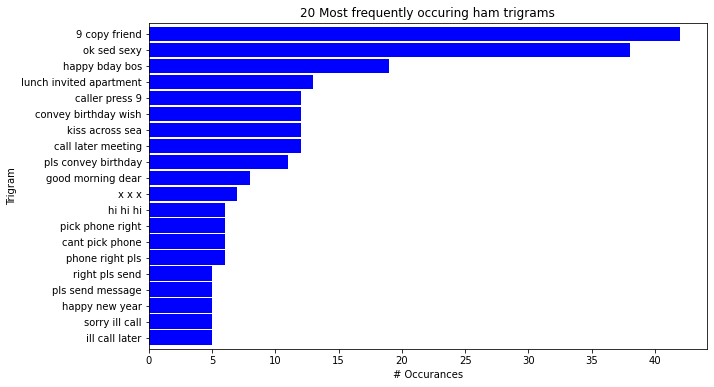

In [19]:
#Create the plot
top_20_ham_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10,6))

#Set the labels
plt.title('20 Most frequently occuring ham trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

#Clean up formatting for labels
ticks, _ = plt.yticks()
labels = top_20_ham_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

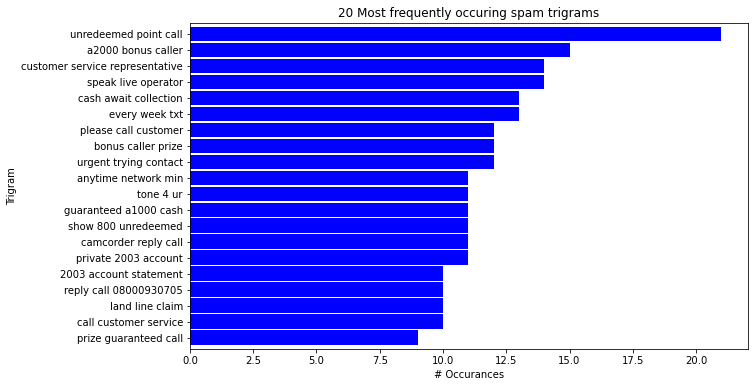

In [20]:
#Create the plot
top_20_spam_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10,6))

#Set the labels
plt.title('20 Most frequently occuring spam trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

#Clean up formatting for labels
ticks, _ = plt.yticks()
labels = top_20_spam_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

### Explore the blog articles using the techniques discussed in the exploration lesson.

#### Acquire the data

In [21]:
#Use functions from acquire module to acquire the data

urls = ['https://codeup.com/codeups-data-science-career-accelerator-is-here/', 'https://codeup.com/data-science-myths/', 
        'https://codeup.com/data-science-vs-data-analytics-whats-the-difference/', 'https://codeup.com/10-tips-to-crush-it-at-the-sa-tech-job-fair/',
        'https://codeup.com/competitor-bootcamps-are-closing-is-the-model-in-danger/']

codeup_df = acquire.get_blog_articles(urls)

#### Prepare the data

In [22]:
#clean to hold the normalized and tokenized original with the stopwords removed.
codeup_df['clean'] = codeup_df['content'].apply(lambda x: prepare.remove_stopwords(prepare.tokenize(prepare.basic_clean(x))))


In [23]:
#Combine the cleaned up blog words
blog_words = ' '.join(codeup_df.clean)
blog_words

'rumors true time arrived codeup officially opened applications new data science career accelerator 25 seats available immersive program one kind san antonio help land job glassdoors 1 best job americadata science method providing actionable intelligence data data revolution hit san antonio resulting explosion data scientist positions across companies like usaa accenture booz allen hamilton heb weve even seen utsa invest 70 cybersecurity center school data science built program specifically meet growing demands industryour program 18 weeks long fulltime handson projectbased curriculum development instruction led senior data scientist maggie giust worked heb capital group rackspace along input dozens practitioners hiring partners students work real data sets realistic problems entire data science pipeline collection deployment receive professional development training resume writing interviewing continuing education prepare smooth transition workforcewe focus applied data science immedi

In [24]:
#Split the words
words = re.sub(r'[^\w\s]', '', blog_words).split()

#return word counts as a series
word_counts = pd.Series(words).value_counts()

#preview the series
word_counts

words_df = pd.DataFrame(word_counts)
words_df.columns = ['n']
words_df

,n
data,69
science,25
learning,19
machine,14
job,13
...,...
puzzle,1
expertise,1
false,1
cohort,1


In [25]:
#Sort the dataframe by the word counts
words_df.sort_values(by='n', ascending=False).head(10)

,n
data,69
science,25
learning,19
machine,14
job,13
like,11
model,11
company,10
one,9
new,9


In [26]:
#Create a bigram of words
top_15_bigrams = (pd.Series(nltk.ngrams(words, 2)).value_counts().head(15))

top_15_bigrams

(data, science)          23
(machine, learning)      13
(data, scientist)         8
(job, fair)               5
(tech, job)               4
(bootcamp, model)         4
(giphy, myth)             4
(big, data)               3
(science, data)           3
(25, seats)               3
(intelligence, data)      3
(seats, available)        3
(data, scientists)        3
(career, accelerator)     3
(iron, yard)              3
dtype: int64

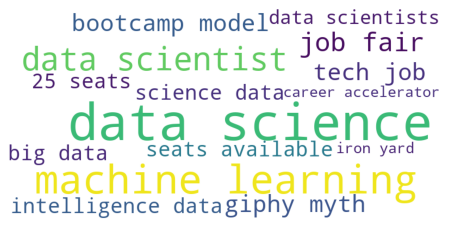

In [27]:
#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

### Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

#### Acquire the data

In [28]:
#Acquire the data using the function from the acquire module
categories = ["business", "sports", "technology", "entertainment", "science", "world"]
news_df = acquire.get_all_news_articles(categories)

#### Prepare the data

In [29]:
#clean to hold the normalized and tokenized original with the stopwords removed.
news_df['clean'] = news_df['content'].apply(lambda x: prepare.remove_stopwords(prepare.tokenize(prepare.basic_clean(x))))

In [30]:
df = news_df[['category', 'clean']]
df.head()

,category,clean
0,business,reliance industries said statement 98 workers ...
1,business,tesla ' billionaire ceo elon musk criticised a...
2,business,amazon monday denied speculations looking acce...
3,business,tesla ceo world ' secondrichest person elon mu...
4,business,inox leisure denied report claimed amazon indi...


In [31]:
def clean(text):
    '''
    A simple function to cleanup text data
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words]

In [32]:
#Breakdown words by the article category
biz_words = clean(' '.join(df.clean[df.category == 'business']))
sports_words = clean(' '.join(df.clean[df.category == 'sports']))
tech_words = clean(' '.join(df.clean[df.category == 'technology']))
ent_words = clean(' '.join(df.clean[df.category == 'entertainment']))
science_words = clean(' '.join(df.clean[df.category == 'science']))
world_words = clean(' '.join(df.clean[df.category == 'world']))

In [33]:
#Get the frequency of the words in each category
biz_freq = pd.Series(biz_words).value_counts()
sports_freq = pd.Series(sports_words).value_counts()
tech_freq = pd.Series(tech_words).value_counts()
ent_freq = pd.Series(ent_words).value_counts()
science_freq = pd.Series(science_words).value_counts()
world_freq = pd.Series(world_words).value_counts()


In [34]:
#create a dataframe with all the wordcounts by category
word_counts = (pd.concat([biz_freq, sports_freq, tech_freq, ent_freq, science_freq,world_freq], axis=1, sort=True)
                .set_axis(['biz', 'sports', 'tech', 'ent', 'science', 'world'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,biz,sports,tech,ent,science,world
0,0,0,0,0,1,0
004,0,0,0,0,1,0
1,0,0,1,1,1,0
10,1,1,1,0,1,0
100,1,1,1,0,0,0


In [35]:
#Create a bigram of business words
top_15_biz_bigrams = (pd.Series(nltk.ngrams(biz_words, 2)).value_counts().head(15))

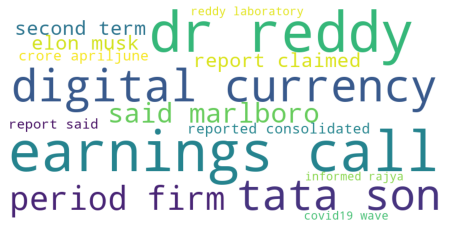

In [36]:
#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_biz_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

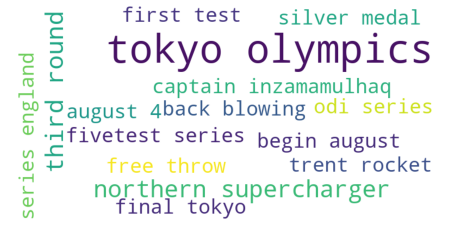

In [37]:
#Create a bigram of sports words
top_15_sports_bigrams = (pd.Series(nltk.ngrams(sports_words, 2)).value_counts().head(15))

#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_sports_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

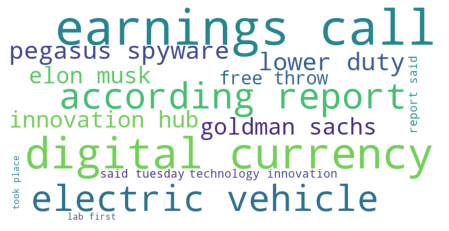

In [38]:
#Create a bigram of tech words
top_15_tech_bigrams = (pd.Series(nltk.ngrams(tech_words, 2)).value_counts().head(15))

#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_tech_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

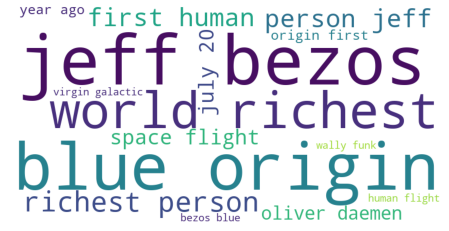

In [39]:
#Create a bigram of science words
top_15_science_bigrams = (pd.Series(nltk.ngrams(science_words, 2)).value_counts().head(15))

#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_science_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()